In [1]:
%matplotlib inline

In [2]:
%run OmniglotInceptionV3ClusterAndClassify.py
random_state=0
np.random.seed(random_state)
skf, skf_cv = spliters(random_state, cv_repeats=5)

In [3]:
results_path = "./OmniglotInceptionV3ClusterAndClassify/understanding_hparams_5x2/"
os.makedirs(results_path, exist_ok=True)

# Trying to unterstand - Cluster and classification of inceptionV3 features

## 10 classes

Experiments on one common episode with 10 classes to explore hyper parameters and get a feel of their sensibility.

Bellow we sample an episode on the data.

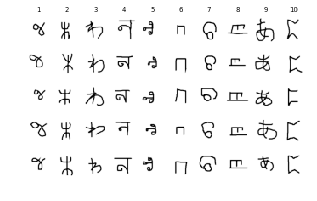

In [4]:
N = 10
X_imgs, X, y = gen_omniglot(N=N,random_seed=random_state)
plt.gcf().set_size_inches(5,3)
plt.savefig(os.path.join(results_path, 'omniglot_examples.eps'), dpi=300)

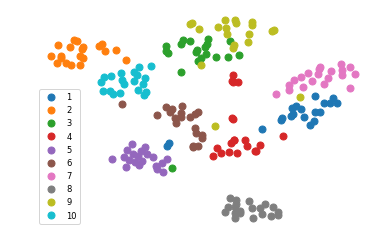

In [5]:
np.random.seed(0)
plot2D(X, y, method='tsne')
plt.title('')
#plt.tick_params(length=0,labelsize=0)
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(6,4)
plt.legend(loc='best', fontsize='small')
plt.savefig(os.path.join(results_path,"TSNE_omniglot_example.eps"))

## Base model on 10 classes

Exploring hyperparams on a large interval.

In [6]:
path = os.path.join(results_path, 'analysing_base_models')
os.makedirs(path, exist_ok=True)
file = os.path.join(path, 'results.pkl')
if os.path.exists(file):
    res_dict = pd.read_pickle(file)
else:
    np.random.seed(random_state)
    res_dict = classify_cluster_softmax(
        X,y, 
        n_Cs=10, Cs_lim=(-3,8),
        n_n_clusters=10, n_clusters_lim=(1,3),
        models_to_test=['l1_plain', 'l2_plain'],
        return_model=True)
    pd.to_pickle(res_dict, file)

In [7]:
reportl1 = Report('analysing_base_models', res_dict, model='l1_plain', directory=results_path)
reportl2 = Report('analysing_base_models', res_dict, model='l2_plain', directory=results_path)

### L1 penalty

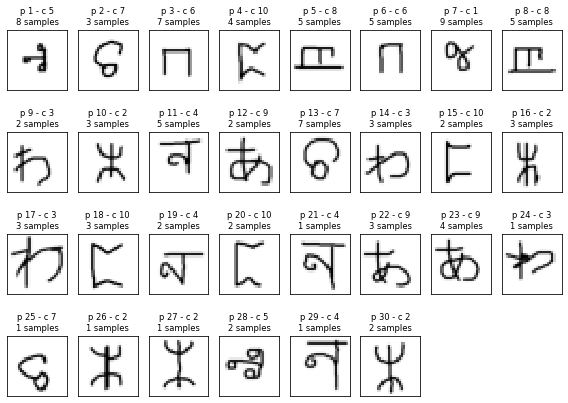

In [8]:
reportl1.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.tight_layout()

In [9]:
reportl1.wc_stats()
reportl1.params()

sparsity @ tol=0.1 0.2866666666666666
mean:  3.2144758902808097 std:  16.92046518749843
parameters:  {'classify__penalty': 'l1', 'classify__shortcut': 0.0, 'classify__tol': 0.1, 'classify__C': 77.42636826811278, 'cluster__class_weight': 0.0, 'classify__solver': 'saga', 'classify__use_shortcut': False, 'cluster__n_clusters': 30}


In [10]:
# plt.figure()
# plt.imshow(modell1[0].best_estimator_.named_steps.cluster.cluster_centers_class_)

proto per class:  [1.00921672 5.         4.00000181 4.         2.         2.
 2.9907828  2.         2.99999866 4.        ]


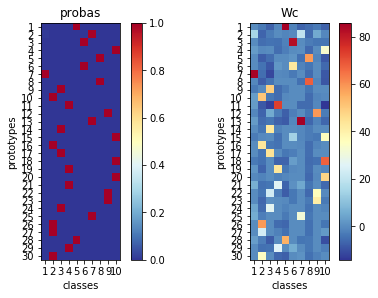

In [11]:
reportl1.visualize_weights()

When plotting the closest images, also annotated information on closest and farthest training point (attributed to that prototype). When no point was atributed (indicated by 0 pts), distances correspond to closest and farthest point over all training points.

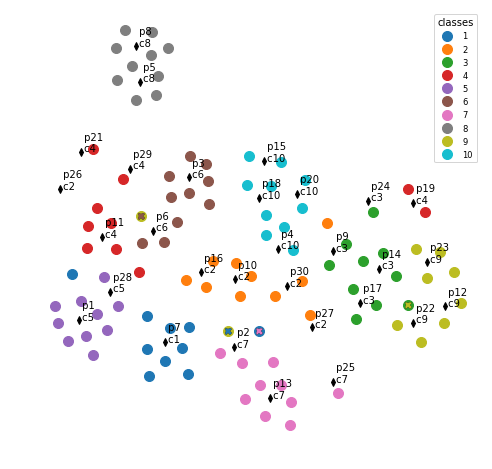

In [12]:
np.random.seed(0)
reportl1.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False)
fig = plt.gcf()
fig.set_size_inches(8,8)
reportl1.savefig('plot2D_tsne.eps')

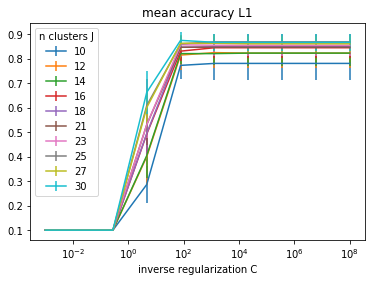

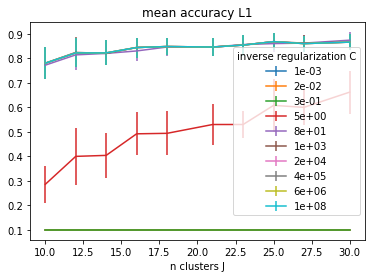

In [13]:
reportl1.main_parameter_grids()

### L2 penalty

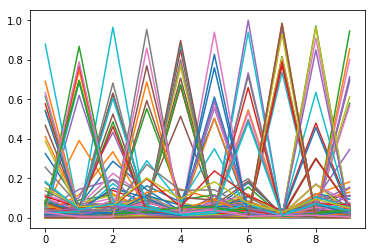

In [8]:
from scipy.stats import entropy
train, test = reportl2._split(X, y)
plt.figure()
plt.plot(reportl2.model.best_estimator_.predict_proba(X[train]).T)

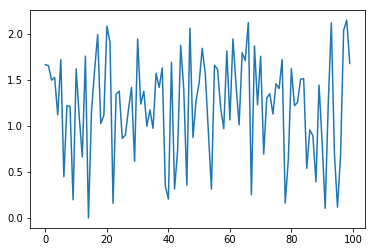

In [10]:
plt.figure()
plt.plot(entropy(reportl2.model.best_estimator_.predict_proba(X[train]).T))

In [14]:
reportl2.wc_stats()
reportl2.params()

sparsity @ tol=0.1 0.0040000000000000036
mean:  -3.1263880373444406e-16 std:  19.033285427509757
parameters:  {'classify__penalty': 'l2', 'classify__shortcut': 0.0, 'classify__C': 1291.5496650148852, 'cluster__class_weight': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'cluster__n_clusters': 25}


proto per class:  [2.99082628 3.         3.00000272 2.00000001 2.         2.
 2.00917372 2.         3.99999726 2.        ]


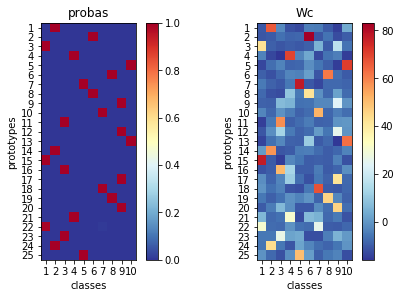

In [15]:
reportl2.visualize_weights()

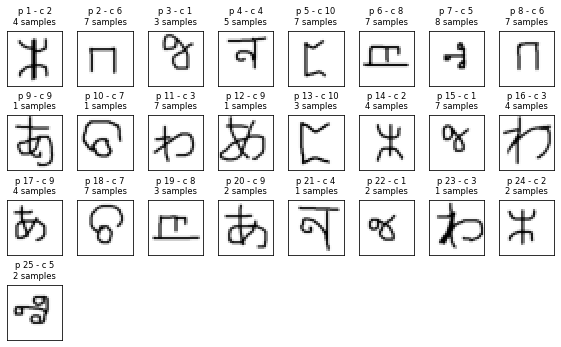

In [16]:
reportl2.closest_images(X_imgs, X, y, show_distances=False)
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(8,5)
reportl2.savefig('closest_images.eps')

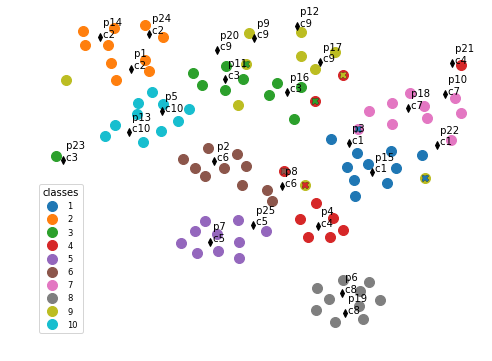

In [140]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', cluster_limits=False, arrows=False)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne.eps')

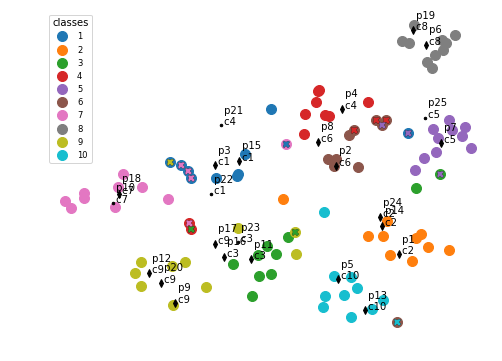

In [141]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', split='test', cluster_limits=False, arrows=False)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne_test.eps')

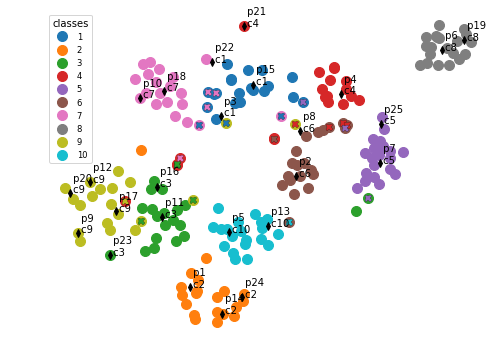

In [142]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', split='both', cluster_limits=False, arrows=False, perplexity=40)
fig = plt.gcf()
fig.set_size_inches(8,6)
reportl2.savefig('plot2D_tsne_all.eps')

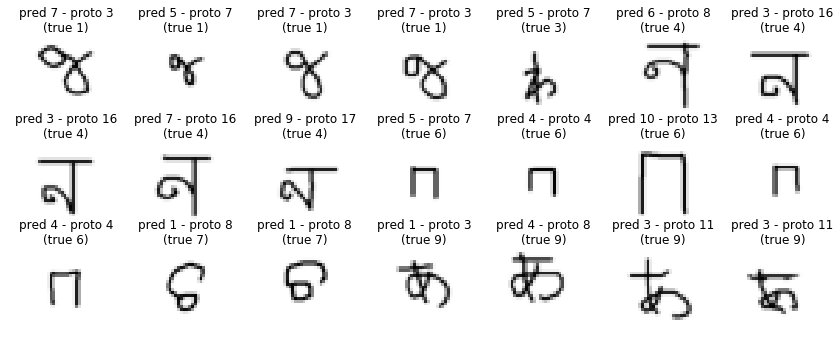

In [144]:
preds = reportl2.model.best_estimator_.predict(X)
misclassified = np.ix_(reportl2.model.best_estimator_.predict(X)!=y)[0].tolist()
prototype = reportl2.model.best_estimator_.named_steps.cluster.predict(X)
ncols = 7
nrows = int(np.ceil(len(misclassified)/ncols))
ix = 0
plt.figure(figsize=(12,5))
for i in range(nrows):
    for j in range(ncols):
        if ix < len(misclassified):
            miss_ix = misclassified[ix]
            plt.subplot2grid((nrows, ncols), (i,j))
            image = X_imgs[miss_ix,:,:]
            plt.imshow(image, cmap='Greys_r')
            plt.axis('off')
            title = 'pred %s - proto %d\n(true %s)'% (preds[miss_ix]+1, prototype[miss_ix]+1, y[miss_ix]+1)
            plt.title(title)
            ix+=1
plt.tight_layout(w_pad=-1,h_pad=-2)
reportl2.savefig('misclassified.eps')

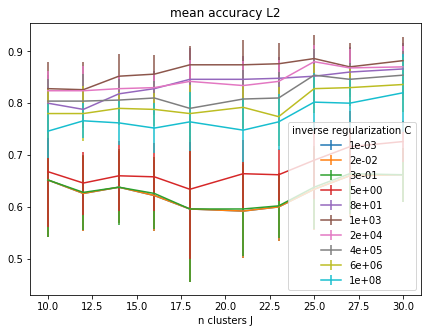

In [20]:
_ = reportl2.parameter_grid(index=['param_cluster__n_clusters'],
            columns=['param_classify__C'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('n_clusters_C.eps')

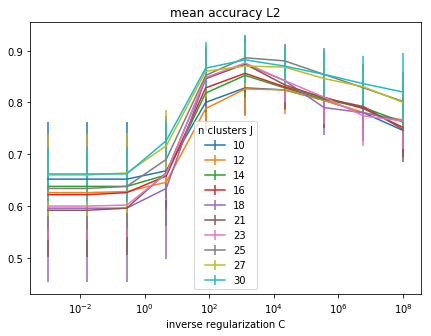

In [21]:
_ = reportl2.parameter_grid(index=['param_classify__C'],
            columns=['param_cluster__n_clusters'], fix='all')
plt.gcf().set_size_inches(7,5)
reportl2.savefig('C_n_clusters.eps')

## Adding a classification loss via using class labels as dimensions
Exploring a smaler range for the parameters already observed. Study class weight param.

In [22]:
path = os.path.join(results_path, 'analysing_class_weight_models')
os.makedirs(path, exist_ok=True)
file = os.path.join(path, 'results.pkl')
if os.path.exists(file):
    res_dict = pd.read_pickle(file)
else:
    np.random.seed(random_state)
    res_dict = classify_cluster_softmax(
        X,y, 
        n_Cs=3, Cs_lim=(2,4),
        n_n_clusters=3, n_clusters_lim=(1,3),
        n_class_weights=10, class_weight_lim=(0,5),
        models_to_test=['l1_noshortcut', 'l2_noshortcut'],
        return_model=True)
    pd.to_pickle(res_dict, file)

In [23]:
reportl1 = Report('analysing_class_weight_models', res_dict, model='l1_noshortcut', directory=results_path)
reportl2 = Report('analysing_class_weight_models', res_dict, model='l2_noshortcut', directory=results_path)

In [24]:
reportl1.wc_stats()
reportl1.params()

sparsity @ tol=0.1 0.010000000000000009
mean:  2.564374933361195 std:  89.67512817951854
parameters:  {'classify__shortcut': 0.0, 'classify__tol': 0.1, 'classify__penalty': 'l1', 'cluster__class_weight': 2.2222222222222223, 'classify__solver': 'saga', 'classify__use_shortcut': False, 'classify__C': 1000.0, 'cluster__n_clusters': 10}


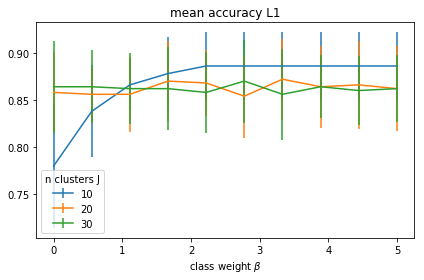

In [25]:
reportl1.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl1.savefig('class_weight_n_clusters.eps')

In [26]:
reportl2.wc_stats()
reportl2.params()

sparsity @ tol=0.1 0.013333333333333308
mean:  -1.5987211554602254e-16 std:  4.707172367783154
parameters:  {'classify__shortcut': 0.0, 'classify__penalty': 'l2', 'cluster__class_weight': 5.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'classify__C': 100.0, 'cluster__n_clusters': 30}


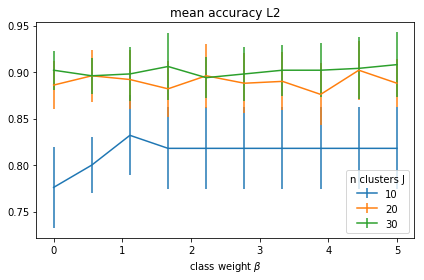

In [27]:
reportl2.parameter_grid(index=['param_cluster__class_weight',],
    columns=['param_cluster__n_clusters'], fix='all')
plt.tight_layout()
reportl2.savefig('class_weight_n_clusters.eps')

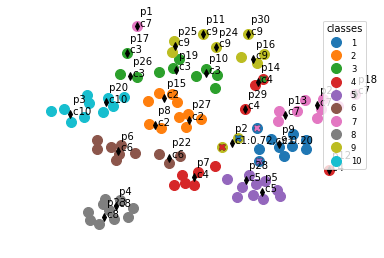

In [28]:
np.random.seed(0)
reportl2.plot2D(X,y, method='tsne', perplexity=30, cluster_limits=False, arrows=False)

In [29]:
reportl2.params()

parameters:  {'classify__shortcut': 0.0, 'classify__penalty': 'l2', 'cluster__class_weight': 5.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': False, 'classify__C': 100.0, 'cluster__n_clusters': 30}


## Balancing between our model and a simple softmax with a shortcut
Model now has a shorcut from the features to the softmax layer. 
Shorcut value is between 0 (only our model) and 1 (only features+softmax)
Idealy approaching shortcut 1 should get us close to softmax perf.
If we have something better in between that means we can help the softmax.

In [30]:
path = os.path.join(results_path, 'analysing_shortcut_model')
os.makedirs(path, exist_ok=True)
file = os.path.join(path, 'results.pkl')
if os.path.exists(file):
    res_dict = pd.read_pickle(file)
else:
    np.random.seed(random_state)
    res_dict = classify_cluster_softmax(
        X,y, 
        n_Cs=3, Cs_lim=(2,4),
        n_n_clusters=3, n_clusters_lim=(1,3),
        n_shortcut=10, 
        models_to_test=['l1_noclassweight', 'l2_noclassweight'],
        return_model=True)
    pd.to_pickle(res_dict, file)

In [31]:
reportl1 = Report('analysing_shortcut_model', res_dict, model='l1_noclassweight', directory=results_path)
reportl2 = Report('analysing_shortcut_model', res_dict, model='l2_noclassweight', directory=results_path)

* Especially for n clsuters = n classes the shortcut helps the most
* hypothesis: 10 clusters is a too low dimensionality, too simple a model. Softmax over the original features is a much more complex model (extra 2048 weights!)

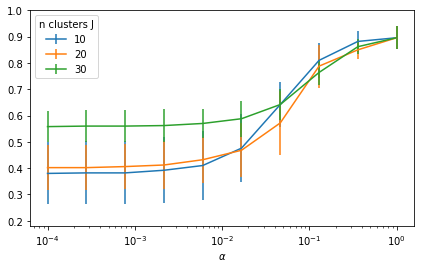

In [32]:
reportl1.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.18,1)
plt.tight_layout()
plt.title('')
reportl1.savefig('shortcut_n_clusters.eps')

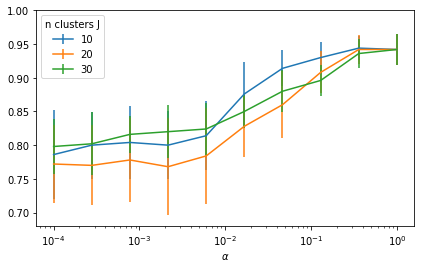

In [33]:
reportl2.parameter_grid(index=['param_classify__shortcut'],
                               columns=['param_cluster__n_clusters'],
                               fix='all')
plt.ylim(0.68,1)
plt.tight_layout()
plt.title('')
reportl2.savefig('shortcut_n_clusters.eps')

proto per class:  [1.00000002e+00 1.00015665e+00 9.99723006e-01 2.51765599e-04
 9.99748193e-01 1.00000005e+00 1.00000002e+00 1.00000001e+00
 1.00032637e+00 1.99979391e+00]
parameters:  {'classify__shortcut': 0.3593813663804626, 'classify__penalty': 'l2', 'cluster__class_weight': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'classify__C': 10000.0, 'cluster__n_clusters': 10}


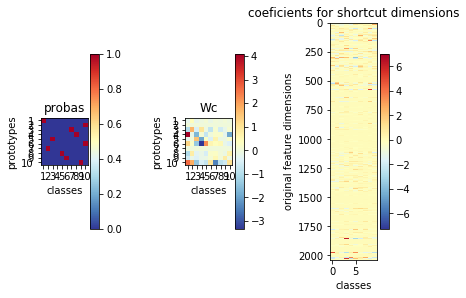

In [34]:
reportl2.visualize_weights()
reportl2.params()

parameters:  {'classify__shortcut': 0.3593813663804626, 'classify__penalty': 'l2', 'cluster__class_weight': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'classify__C': 10000.0, 'cluster__n_clusters': 10}


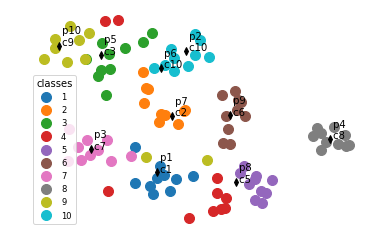

In [36]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30)
reportl2.params()
reportl2.savefig('plot2D_tsne.eps')

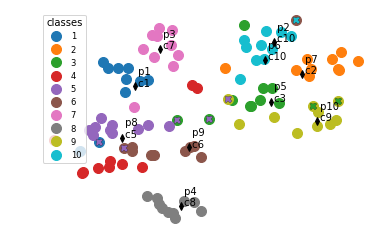

In [37]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30, split='test')
reportl2.savefig('plot2D_tsne_test.eps')

## Class weight and shortcut togheter - do they help eachother?

In [38]:
path = os.path.join(results_path, 'analysing_full_model')
os.makedirs(path, exist_ok=True)
file = os.path.join(path, 'results.pkl')
if os.path.exists(file):
    res_dict = pd.read_pickle(file)
else:
    np.random.seed(random_state)
    res_dict = classify_cluster_softmax(
        X,y, 
        n_Cs=3, Cs_lim=(2,4),
        n_n_clusters=3, n_clusters_lim=(1,3),
        n_class_weights=5, class_weight_lim=(0,2),
        n_shortcut=10, 
        models_to_test=['l1', 'l2'],
        return_model=True)
    pd.to_pickle(res_dict, file)

In [39]:
reportl1 = Report('analysing_full_model', res_dict, model='l1', directory=results_path)
reportl2 = Report('analysing_full_model', res_dict, model='l2', directory=results_path)

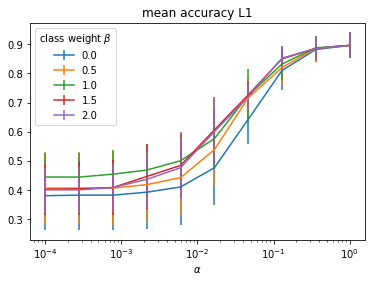

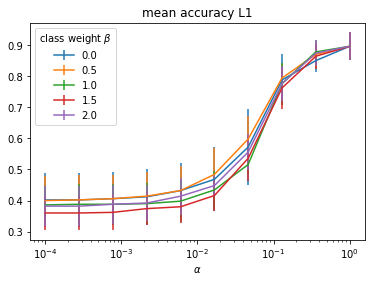

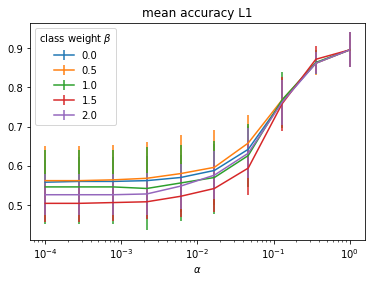

In [40]:
df, t1, terr1 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=10, param_classify__C='best'))
df, t2, terr2 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=20, param_classify__C='best'))
df, t3, terr3 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=30, param_classify__C='best'))

- when shortcut is strong, class weight does not matter 


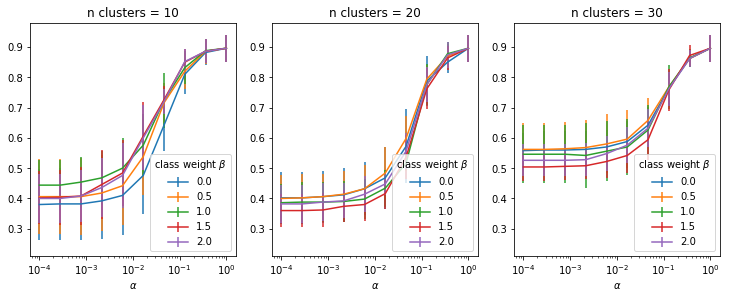

In [41]:
plt.figure(figsize=(10,4))
ts = [t1,t2,t3]
terrs = [terr1, terr2, terr3]
n_clusters = [10,20,30]
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n clusters = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
plt.tight_layout(pad=0.2,w_pad=1)
reportl1.savefig('shortcut_class_weight.eps')

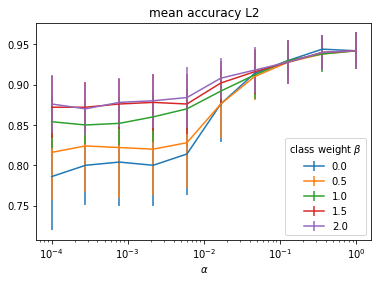

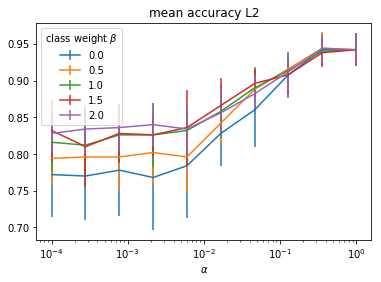

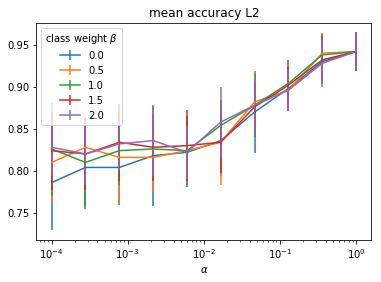

In [42]:
df, t1, terr1 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=10, param_classify__C='best'))
df, t2, terr2 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=20, param_classify__C='best'))
df, t3, terr3 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=30, param_classify__C='best'))

- when shortcut is strong, class weight does not matter 


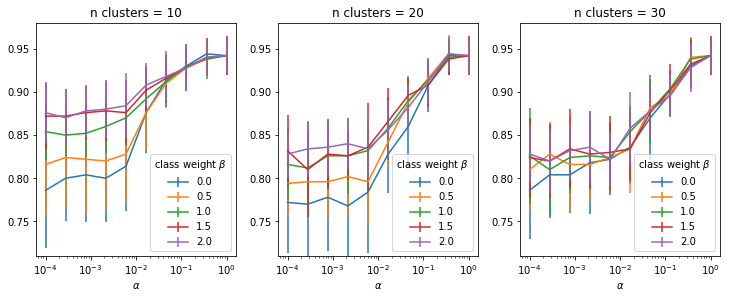

In [43]:
plt.figure(figsize=(10,4))
ts = [t1,t2,t3]
terrs = [terr1, terr2, terr3]
n_clusters = [10,20,30]
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n clusters = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    plt.xscale('log')
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.71,0.98)
plt.tight_layout(pad=0.2,w_pad=1)
reportl2.savefig('shortcut_class_weight.eps')

parameters:  {'classify__shortcut': 0.3593813663804626, 'classify__penalty': 'l2', 'cluster__class_weight': 0.0, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'classify__C': 10000.0, 'cluster__n_clusters': 10}


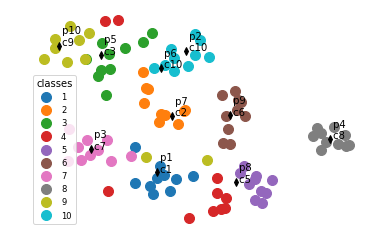

In [44]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30)
reportl2.params()

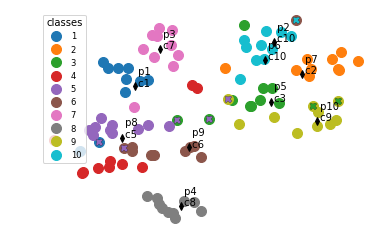

In [45]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30, split='test')

## Class weight and shortcut togheter - linear on shortcut

In [46]:
path = os.path.join(results_path, 'analysing_full_model_linear_shortcut')
os.makedirs(path, exist_ok=True)
file = os.path.join(path, 'results.pkl')
if os.path.exists(file):
    res_dict = pd.read_pickle(file)
else:
    np.random.seed(random_state)
    res_dict = classify_cluster_softmax(
        X,y, 
        n_Cs=3, Cs_lim=(2,4),
        n_n_clusters=3, n_clusters_lim=(1,3),
        n_class_weights=5, class_weight_lim=(0,2),
        n_shortcut=10, shortcut_lim=(0,1), shortcut_scale='linear',
        models_to_test=['l1', 'l2'],
        return_model=True)
    pd.to_pickle(res_dict, file)

In [47]:
reportl1 = Report('analysing_full_model_linear_shortcut', res_dict, model='l1', directory=results_path)
reportl2 = Report('analysing_full_model_linear_shortcut', res_dict, model='l2', directory=results_path)

In [48]:
reportl2.params()

parameters:  {'classify__penalty': 'l2', 'classify__shortcut': 0.7777777777777777, 'classify__C': 10000.0, 'cluster__class_weight': 1.5, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__n_clusters': 30}


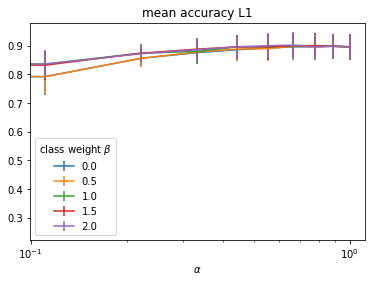

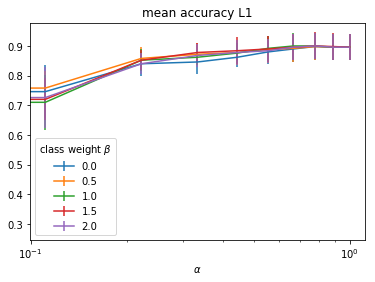

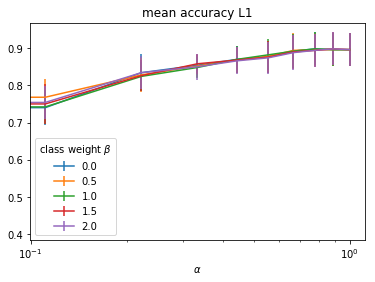

In [49]:
df, t1, terr1 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=10, param_classify__C='best'))
df, t2, terr2 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=20, param_classify__C='best'))
df, t3, terr3 = reportl1.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=30, param_classify__C='best'))

- when shortcut is strong, class weight does not matter 


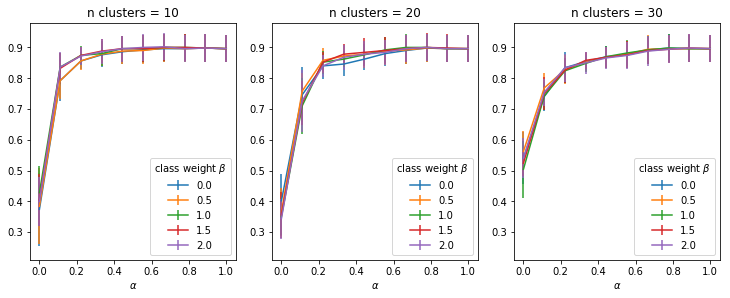

In [50]:
plt.figure(figsize=(10,4))
ts = [t1,t2,t3]
terrs = [terr1, terr2, terr3]
n_clusters = [10,20,30]
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n clusters = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.21,0.98)
plt.tight_layout(pad=0.2,w_pad=1)
reportl1.savefig('shortcut_class_weight.eps')

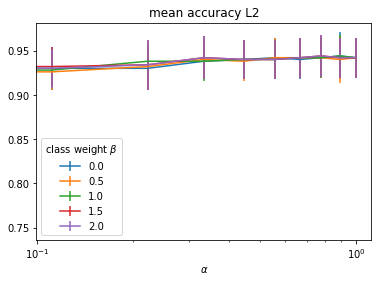

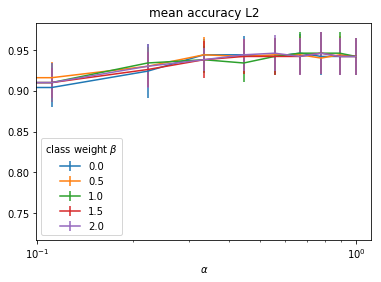

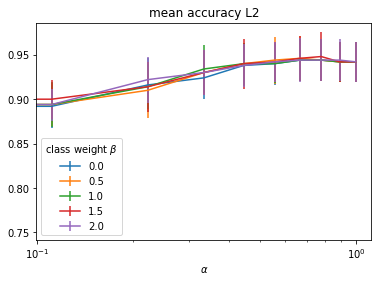

In [51]:
df, t1, terr1 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=10, param_classify__C='best'))
df, t2, terr2 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=20, param_classify__C='best'))
df, t3, terr3 = reportl2.parameter_grid(index=['param_classify__shortcut'],
    columns=['param_cluster__class_weight'], fix=dict(param_cluster__n_clusters=30, param_classify__C='best'))

- when shortcut is strong, class weight does not matter 


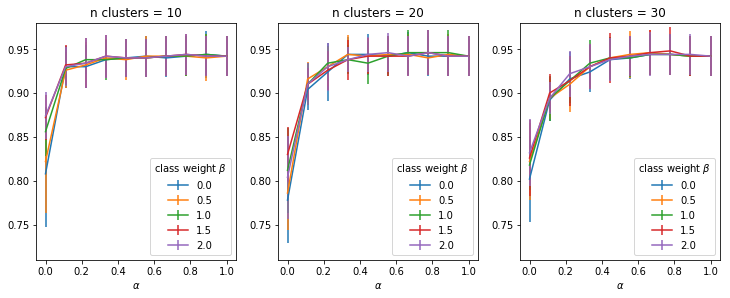

In [52]:
plt.figure(figsize=(10,4))
ts = [t1,t2,t3]
terrs = [terr1, terr2, terr3]
n_clusters = [10,20,30]
for i, t in enumerate(ts): 
    ax = plt.subplot(1,3,i+1)
    plt.title('n clusters = %d' % n_clusters[i])
    t.plot(ax=ax, style=[':d',':.',':+']*20,yerr=terrs[i])
    ax.set_xlabel(transform_label(ax.get_xlabel()))
    ax.set_xlabel(r'$\alpha$')
    new_title = transform_label(ax.get_legend().get_title().get_text())
    plt.legend(title=r'class weight $\beta$', loc='lower right')
    plt.ylim(0.71,0.98)
plt.tight_layout(pad=0.2,w_pad=1)
reportl2.savefig('shortcut_class_weight.eps')

parameters:  {'classify__penalty': 'l2', 'classify__shortcut': 0.7777777777777777, 'classify__C': 10000.0, 'cluster__class_weight': 1.5, 'classify__solver': 'lbfgs', 'classify__use_shortcut': True, 'cluster__n_clusters': 30}


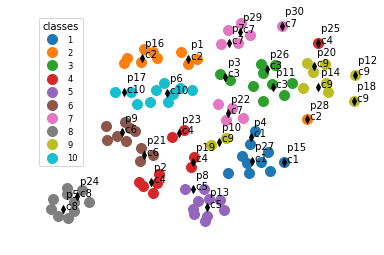

In [53]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30)
reportl2.params()

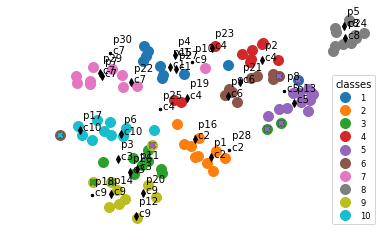

In [54]:
np.random.seed(1)
reportl2.plot2D(X,y, method='tsne', perplexity=30, split='test')